# Markov Random Fields (MRF) for Image Segmentation

MRF is a probabilistic framework in which we use contextual information to perform some type of image analysis task. In this exercise we use it to perform image segmentation. We do this because Markov Random Fields are good at handling noise (insert smoothness) in segmentation problems. In MRF image segmentation, we try to maximise our *a posterior* probability which is a combination of a likelihood term and a prior (smoothness) term. Maximising *posterior* probability is the same as minimizing the posterior energy. This means that we have two problems in MRF - a modelling problem and an optimization problem. 

First we dicuss the modelling problem in which we choose to model our pixel neighbourhoods based on 1-clique and 2-clique potentials. We model likelihood as 1-clique potentials. We choose that a pixel is more likely to be assigned a class based on how close it's intensity is from the average pixel intensity within a class. We model the prior term using 2-clique potentials. We can choose to penalize a pixel class assignment based on its nearest neighbours, which is what we choose to do here. We try to minimize the function:

$E(f) = U(f|d) = U(d|f) + U(f)$.

Which, given our modelling technique is: $E(f) = \sum_{i\in C_1} V_1(f_i) + \sum_{i,j\in C_2} V_2(f_i, f_j)$. We then define $V_1(f_i) = \alpha(\mu(f_i)-d_i)^2$ and $V_2(f_i, f_j) = \{0 \text{ if } f_i = f_j, \beta \text{ otherwise}\}$.

This is the modelling part. We now have to optimize the function, which means finding the value of each pixel assignment at which the objective function takes on a minimum. We do this by constructing a graph from the energy function and then find a minimum *s-t* cut which gives us the optimal solution in polynomial time.

We try to obtain an optimal segmentation by tuning the two hyperparameters $\alpha$ and $\beta$. $\beta$ is the hyperparameter we have to tune the most, as it affects how strongly the 2-clique affects the smoothness of our segmentation.

* Practical illustration of intensity only with noisy image
* Compute energies using other simpler methods (and ground truth).
* Show optimization using Graph Cuts (build graph with s-t being classes and internal paths being class change costs).
* Show real-life example of bone tibia - low beta means that we end up segmenting noise as well. High beta means that we smoothen out air pockets. 


In [4]:
#import cv2
import imageio
import numpy as np
import matplotlib.pyplot as plt
import scipy
import sklearn
from scipy import ndimage
import math

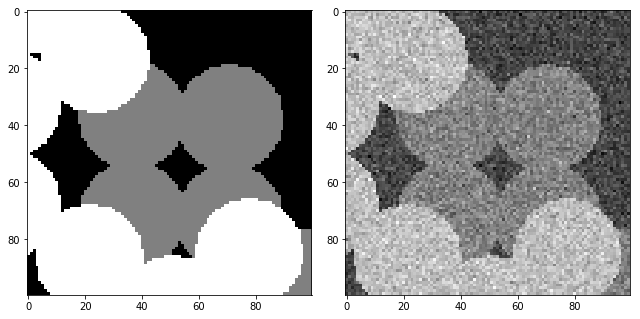

In [7]:
img_true = imageio.imread('data/data/noise_free_circles.png').astype(float)
img_noise = imageio.imread('data/data/noisy_circles.png').astype(float)

fig1, f1_axes = plt.subplots(ncols=2, nrows=1, constrained_layout=False, figsize=(9,6))
f1_axes[0].imshow(img_true, cmap = "gray")
f1_axes[1].imshow(img_noise, cmap = "gray")
fig1.show()
fig1.tight_layout()

### What does the histogram say about obtaining an image segmentation using e.g. thresholding?
From the histogram we see, that any segmentation method only considering the pixel intensities will have a considerable error-rate. From decision theory we have, that the such a method ideally would consider.....

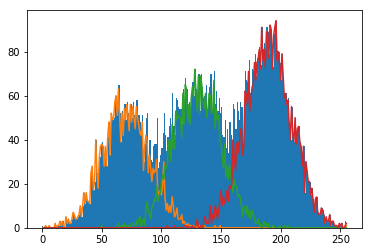

In [8]:
def segmentationHistogram(img_true, img_noise, chist=True):
    hist_graph = np.zeros((3, 255))
    
    classes = {70. : 0,
               130. : 1,
               190. : 2}
    
    for i, row in enumerate(img_true):
        for j, _ in enumerate(row):
            intensity = math.floor(img_noise[i,j])-1
            if chist:
                clss = classes[img_true[i,j]]
                hist_graph[clss, intensity] +=1

    plt.hist(img_noise.flatten(), bins=255)
    if chist:
        plt.plot(np.array(range(255))+1, hist_graph[0,:])
        plt.plot(np.array(range(255))+1, hist_graph[1,:])
        plt.plot(np.array(range(255))+1, hist_graph[2,:])
    plt.show()
    return

segmentationHistogram(img_true, img_noise)

### A function to compute segmentation energies is implemented:

It should be noted, that the edges are not considered.

Optimal configuration: 
Likelihood:  1999.904
Prior:  1438
3437.904
Threshold configuration: 
Likelihood:  1650.4640000000002
Prior:  7321
8971.464
Median filtering configuration: 
Likelihood:  2143.304
Prior:  1487
3630.304


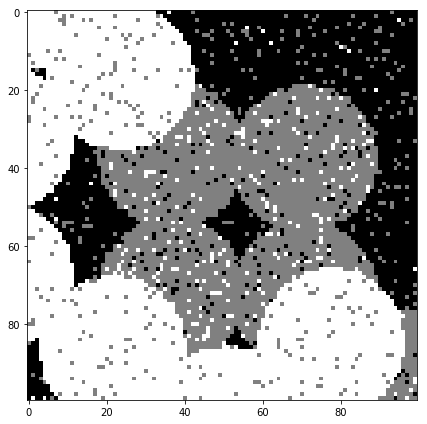

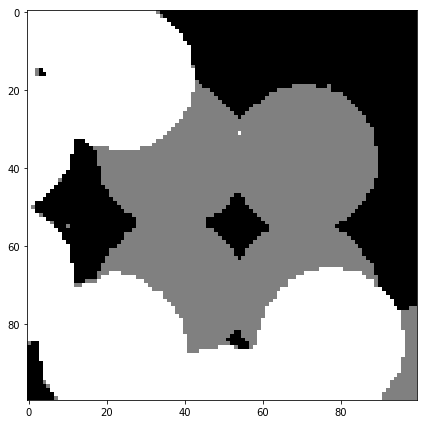

In [15]:
alpha = 0.0005

def V2(f1, f2):
    if f1==f2:
        return 0
    else:
        return 1

def U_l(alpha, img_noise, config): # config contains the intensity values from each class
    return(np.sum(alpha*(config - img_noise)**2))

def U_p(config, beta=1):
    r, c = config.shape
    s=0
    for i in range(r-2):
        i2=i+1
        for j in range(c-2):
            j2=j+1
            s=s+beta*(V2(config[i,j], config[i+1,j])+V2(config[i,j], config[i-1,j])+V2(config[i,j], config[i,j+1])+V2(config[i,j], config[i,j-1]))
    return(s)

def segmentationEnergy(alpha, img_noise, config):
    like = U_l(alpha, img_noise, config)
    prior = U_p(config)
    print("Likelihood: ", like)
    print("Prior: ", prior)
    return(like + prior)

# The segmentation Energy for the optimal configuration:
print("Optimal configuration: ")
print(segmentationEnergy(alpha, img_noise, img_true))

# Make U_p efficient:
def thresholdConfig(thres1, thres2, img_noise):
    r, c = img_noise.shape
    config = np.zeros((r,c))
    for i in range(r):
        for j in range(c):
            val = img_noise[i,j]
            if val < thres1:
                config[i,j]=70.0
            elif thres1 < val and val < thres2:
                config[i,j]=130.0
            else:
                config[i,j]=190.0
    return config

config1 = thresholdConfig(100, 160, img_noise)

# Plots the thresholded segmentation:
fig2, f2_axes = plt.subplots(ncols=1, nrows=1, constrained_layout=False, figsize=(9,6))
f2_axes.imshow(config1, cmap = "gray")
fig2.show()
fig2.tight_layout()
# The segmentation energy is computed for the thresholding configuration:
print("Threshold configuration: ")
print(segmentationEnergy(alpha, img_noise, config1))

img_median = ndimage.median_filter(config1, size=(3,3))
fig3, f3_axes = plt.subplots(ncols=1, nrows=1, constrained_layout=False, figsize=(9,6))
f3_axes.imshow(img_median, cmap = "gray")
fig3.show()
fig3.tight_layout()
print("Median filtering configuration: ")
print(segmentationEnergy(alpha, img_noise, img_median))

### Graph Cuts for MRF:


In [19]:
d = np.array([179, 174, 182, 162, 175, 165])
import maxflow
# Testing the gender assignement case.
beta = 100
# Create a graph with integer capacities.
g = maxflow.Graph[float](2, 2)
# Add two (non-terminal) nodes. Get the index to the first one.
nodes = g.add_nodes(6)

g.add_edge(nodes[0], nodes[1], beta, beta)
g.add_edge(nodes[1], nodes[2], beta, beta)
g.add_edge(nodes[2], nodes[3], beta, beta)
g.add_edge(nodes[3], nodes[4], beta, beta)
g.add_edge(nodes[4], nodes[5], beta, beta)

# Set the capacities of the terminal edges...
clqe1 = (d-181)**2
clqe2 = (d-165)**2

g.add_tedge(nodes[0], clqe1[0], clqe2[0])
g.add_tedge(nodes[1], clqe1[1], clqe2[1])
g.add_tedge(nodes[2], clqe1[2], clqe2[2])
g.add_tedge(nodes[3], clqe1[3], clqe2[3])
g.add_tedge(nodes[4], clqe1[4], clqe2[4])
g.add_tedge(nodes[5], clqe1[5], clqe2[5])

#g.add_tedge(nodes[0], 2, 5)
# ...for the second node.
#g.add_tedge(nodes[1], 9, 4)

flow = g.maxflow()
print("Maximum flow:", flow)
print("Segment of the node 0:", g.get_segment(nodes[0]))
print("Segment of the node 1:", g.get_segment(nodes[1]))

opt_conf = []
for i in range(6):
    opt_conf.append(g.get_segment(nodes[i]))
print(opt_conf)
# Note: the get_segement returns 1 when the node belongs to the SOURCE, and 0 when the node belongs to the SINK.

Maximum flow: 263.0
Segment of the node 0: 1
Segment of the node 1: 1
[1, 1, 1, 0, 0, 0]


Big beta: Then contains big prior -> incentivices that neighbouring classes are the same.

beta=0: The classification will only rely on the likelihood term.

# Bone tibia example

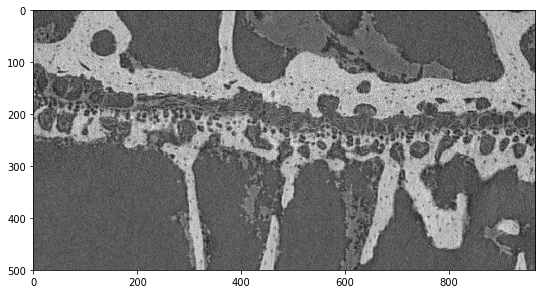

In [25]:
img_tibia = imageio.imread('data/data/V8_10X_x502.png').astype(float)*(1/(2**16-1))
fig2, f2_axes = plt.subplots(ncols=1, nrows=1, constrained_layout=False, figsize=(9,6))
f2_axes.imshow(img_tibia, cmap = "gray")
fig2.show()

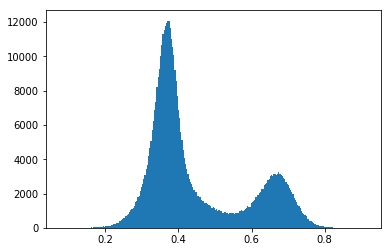

In [26]:
# Histogram for the mouse tibia picture:
segmentationHistogram(img_tibia, img_tibia, False)

Maxflow:  2157.970191998665


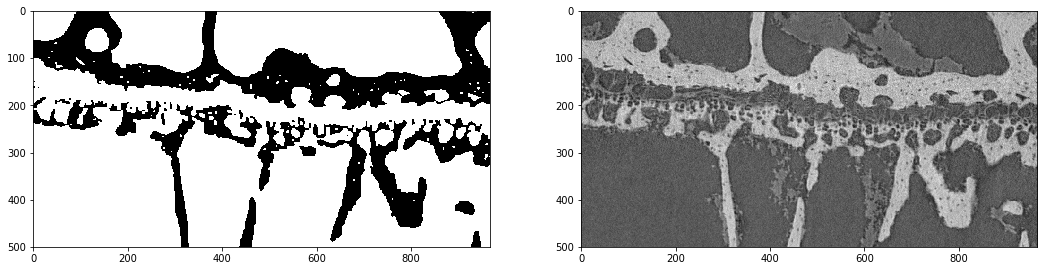

In [32]:
#img_tibia = imageio.imread('data/data/noisy_circles.png').astype(float)*(1/(2**16-1))



beta=0.02

# Create the graph.
g = maxflow.Graph[float]()
# Add the nodes. nodeids has the identifiers of the nodes in the grid.
nodeids = g.add_grid_nodes(img_tibia.shape)

# Create matrix describing neigbourhood structure:
structure=np.array([[0,1,0],
                    [1,0,1],
                    [0,1,0]])

# Add non-terminal edges with the same capacity.
g.add_grid_edges(nodeids, weights=beta, structure=structure, symmetric=True)

source_capacity = (0.38 - img_tibia)**2 #relies on first class
sink_capacity = (0.68 - img_tibia)**2 #relies on second class
# Note: 0.38 and 0.68 is determined from the histograms

# Add the terminal edges (likelihood weights):
g.add_grid_tedges(nodeids, source_capacity, sink_capacity)
# Find the maximum flow.
print("Maxflow: ", g.maxflow())
# Get the segments of the nodes in the grid.
sgm = g.get_grid_segments(nodeids)
fig3, f3_axes = plt.subplots(ncols=2, nrows=1, constrained_layout=False, figsize=(18,12))
f3_axes[1].imshow(img_tibia, cmap = "gray")
f3_axes[0].imshow(sgm, cmap = "gray")
fig3.show()